# BigTable MTLM - dataset perplexity testing

Aim of this notebook:
1. Generate student + question datasets
2. Generate N sets of encounters
3. Report on agreement between these sets

The error between the datasets (for large N) is the inherent probabilistic error in the model
- How does this translate to tolerances in the $\alpha$ and $\delta$ parameters

## Model perplexity
A model $q$ is used to predict the values of a set of samples, $\mathbf{x}$.  Perplexity is defined as:

\\[{perplex}_{q}(\mathbf{x}) = b^{-\frac{1}{N}\Sigma_{i=1}^{N}{log_{b}(q(x_i))}}\\]

Perplexity is a measure of `surprise' as a divergence from the predictions that are seen in the true values.


In [1]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

# p = 1 / (1 + e^-z)
# -ln((1/ p) - 1) = z
-log((1/0.993) - 1)


Using TensorFlow backend.


4.954820514989862

In [2]:
generate_student_name()

'HUCH SUD '

In [2]:
sigmoid = lambda z: 1/(1+exp(-z))

class Question():
    def __init__(self, qix, min_diff, max_diff, nt, n_active):
        self.id = qix

        if n_active:
            if len(n_active)==2:
                min_active = n_active[0]
                max_active = n_active[1]
                n_c =  numpy.random.choice(range(min_active, max_active+1))
        else:
            n_c = nt

        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
        not_present= 0#min_diff
        self.betas = [ not_present for _ in range(nt) ]        
  
        for c in choices:
#             self.betas[c] = min_diff
#             self.betas[c] = inv_sigmoid(p) 
#             self.betas[c]=0
            self.betas[c]= uniform(min_diff, max_diff)
    
class Student():
    def __init__(self, ix, mu_th, sd_th, nt=None):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= 0 #min_a
        
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             assume_b = 6#uniform(1,11)
#             assume_pass = uniform(.0001**(1/n_c), .9999**(1/n_c))
# #             p = random.uniform(.0001**(1/n_c), .9999**(1/n_c))
# #             p = random.uniform(minp, maxp)
# #             self.thetas[c] = inv_sigmoid(p) + 6
# #             self.thetas[c] = 0
#             z = inv_sigmoid(assume_pass)
#             th = z + assume_b
#             self.thetas[c]= th
            self.thetas[c] = numpy.random.normal(mu_th,sd_th) #uniform(min_a, max_a) 
#             self.thetas[c] = uniform(mu_th-3.0*sd_th,mu_th+3.0*sd_th) #uniform(min_a, max_a) 

In [3]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [4]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
    for th,b in zip(thetas,betas):
#         if b==0:
#             p_pass_step=1.0
#         else:
#             if th==0:
# #                 print("blocking component, ret 0")
#                 return 0
#             else:
        z = (th-b)
        p_pass_step = 1.0 / (1.0 + exp(-z))
# #                 print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [5]:
def create_qs(n_qs, nt, active_limits, beta_min, beta_max):

    max_mag = sqrt((beta_max**2)*nt)
    min_mag = sqrt((beta_min**2)*nt)
    print("Vector length limits:",min_mag,max_mag)

    master_qs = [Question(qix, beta_min,beta_max, nt, active_limits) for qix in range(n_qs)]
    mags = []
    no_comps = []
#     for q in master_qs:
#         comps = [c for c in q.betas if c>0]
#         mag = sqrt(sum([ pow(b, 2) for b in comps ]))
#         print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
#         mags.append(mag)
#         no_comps.append(len(comps))
    
#     plt.hist(mags)
#     plt.show()
#     plt.hist(no_comps)
#     plt.show()
    
#     for q in master_qs:
#         print("qid",q.id,q.betas)
    return master_qs

In [6]:
def create_students(n_students, nt, mu_th, sd_th):

    psi_list = [ Student(psix, mu_th, sd_th, nt=nt) for psix in range(n_students)]
#     mags = []
#     for psi in psi_list[0:30]:
#         print(psi.name, psi.thetas)
#         comps = [c for c in psi.thetas if c>0]
#         mag = sqrt(sum([ pow(b, 2) for b in comps ]))
#         print("{}, skill={:.2f} across {} comps".format(psi.name, mag, len(comps)))
#         mags.append(mag)
    
 ################ PLOTs follow

#     fig,ax = plt.subplots(1,2)
#     fig.set_size_inches(20,10)
    
#     ax[0].hist(mags)
    
#     if nt >1:
#         itemz = array([ s.thetas for s in psi_list ])
#     #     fig.set_size_inches(10, 10)
#         ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
#         for i, txt in enumerate(itemz):
#             ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
#         plt.show()
    
    return psi_list

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [7]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    passes=0
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0

                pp,passed = attempt_q(psi, q)
                if passed:
                    passes+=1
                tup = (psi.id, q.id, passed, passed)
                attempt_n_map[(q.id,psi.id)] += 1
                attempts.append(tup)
#                 print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                att += 1
                qs.remove(qix)
#                 print("len qs is", len(qs))
    gc.collect()
    print("passed {}/{}".format(passes,len(attempts)))
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

In [9]:
# # %%capture
# from IPython.display import clear_output

# serieses = []
# min_errs = []
# n_items = 100
# n_students = 1000
# # desired confusion prop/n mx
# # .5  0 
# #  0 .5

# def gen_run(n_traits, minb, maxb, mu_th, sd_th, min_active_traits, max_active_traits):
#     qs = create_qs(n_items, n_traits, (min_active_traits, max_active_traits), minb, maxb)
# #     #     qs, q_table = create_qs_from_blobs(n_qs, 2, n_traits)
#     ss = create_students(n_students, n_traits, mu_th, sd_th)

#     x = []

#     for _ in range(1):
#         xa, _,_,_ = generate_attempts(qs,ss) # this is our x list of samples
#         x.extend(xa)
    
# #     gaussian_pts = numpy.random.uniform((mu_th-3.0*sd_th),(mu_th+3.0*sd_th), n_students)
# #     uniform_pts = numpy.random.uniform(minb, maxb, n_items)
# #     gaussian_pts = numpy.repeat(gaussian_pts, n_items)
# #     uniform_pts = numpy.tile(uniform_pts, n_students)     
    
#     tp,fp,tn,fn=0,0,0,0
#     base = 2
#     summa=0
#     N = len(x)
#     probs = []
#     for tup in x:
#         (psi_id, q_id, passed, passed) = tup
#         p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)
#         summa += log((p if passed else (1-p)), base)
#         probs.append(p)
        
#         pp = uniform(0,1)
#         if pp <= p:
#             if passed:
#                 tp+=1
#             else:
#                 fp+=1
#         else:
#             if passed:
#                 fn+=1
#             else:
#                 tn+=1

#     acc = (tp+tn)/len(x)
#     print("model acc:",acc)
#     print(tp,fp)
#     print(fn,tn)

#     ppx = pow( base, (-summa/N))
#     print("perplexity is {}".format(ppx))
#     return ((fn + fp) + abs(tp-tn)), probs
    
# dims_scores = {}
# best_probs = {}
# param_freedom = 10
# random.seed()
# seen = set()
# mini = 1
# maxi = 15
# #dimslist = [1,2,3,5,10,25,100]:

# dims = 100

# inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
# min_sprd = inv_sigmoid(0.02**(1/dims))
# mid_sprd = inv_sigmoid(0.5**(1/dims))
# max_sprd = inv_sigmoid(0.98**(1/dims))

# min_b = 1
# max_th = min_b + max_sprd


# best_run = -1

# minb_spd = 2
# maxb_spd = 6

# for maxi in [20]:
#     i=0
#     while i < 100:
#         rnge = uniform(minb_spd, maxb_spd)
#         minb = -rnge/2
#         maxb = rnge/2
        
#         mu_th = uniform(mid_sprd, max_sprd)
#         sd_th = uniform(1,2)
    
#         i+=1
#         print(">>>",i)
#         outz = gen_run(dims, minb, maxb, mu_th, sd_th, dims, dims)
#         balance, probz = outz[0], outz[1]

#         loss = numpy.mean([abs(p-0.5) for p in probz])
        
#         sd = numpy.std(numpy.array(probz))
        
#         print("?",loss,sd)
#         if (dims not in dims_scores) or (dims_scores[dims][0] >= loss and dims_scores[dims][2] < sd):
#             print("+++")
#             dims_scores[dims] = (loss, balance, sd, mu_th,sd_th,minb,maxb)
#             best_probs[dims] = probz
#             best_run = i-1
            

In [8]:
# %%capture
from IPython.display import clear_output
from scipy.stats import kstest

serieses = []
min_errs = []
n_items = 100
n_students = 100
# desired confusion prop/n mx
# .5  0 
#  0 .5

def gen_run(n_traits, minb, maxb, mu_th, sd_th, min_active_traits, max_active_traits):
    qs = create_qs(n_items, n_traits, (min_active_traits, max_active_traits), minb, maxb)
#     #     qs, q_table = create_qs_from_blobs(n_qs, 2, n_traits)
    ss = create_students(n_students, n_traits, mu_th, sd_th)

    x = []

    for _ in range(1):
        xa, _,_,_ = generate_attempts(qs,ss) # this is our x list of samples
        x.extend(xa)
    
#     gaussian_pts = numpy.random.uniform((mu_th-3.0*sd_th),(mu_th+3.0*sd_th), n_students)
#     uniform_pts = numpy.random.uniform(minb, maxb, n_items)
#     gaussian_pts = numpy.repeat(gaussian_pts, n_items)
#     uniform_pts = numpy.tile(uniform_pts, n_students)     
    
    tp,fp,tn,fn=0,0,0,0
    base = 2
    summa=0
    N = len(x)
    probs = []
    for tup in x:
        (psi_id, q_id, passed, passed) = tup
        p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)
        summa += log((p if passed else (1-p)), base)
        probs.append(p)
        
        pp = uniform(0,1)
        if pp <= p:
            if passed:
                tp+=1
            else:
                fp+=1
        else:
            if passed:
                fn+=1
            else:
                tn+=1

    acc = (tp+tn)/len(x)
    print("model acc:",acc)
    print(tp,fp)
    print(fn,tn)

    ppx = pow( base, (-summa/N))
    print("perplexity is {}".format(ppx))
    return ((fn + fp) + abs(tp-tn)), probs
    
dims_scores = {}
best_probs = {}
param_freedom = 10
random.seed()
seen = set()
mini = 1
maxi = 15
#dimslist = [1,2,3,5,10,25,100]:

dims = 100

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
min_sprd = inv_sigmoid(0.02**(1/dims))
mid_sprd = inv_sigmoid(0.5**(1/dims))
max_sprd = inv_sigmoid(0.98**(1/dims))

min_b = 1
max_th = min_b + max_sprd


best_run = -1

minb_spd = 2
maxb_spd = 6

for maxi in [20]:
    i=0
    while i < 1000:
        rnge = uniform(minb_spd, maxb_spd)
        minb = -rnge/2
        maxb = rnge/2
        
        mu_th = uniform(min_sprd, max_sprd)
        sd_th = uniform(1,3)
    
        i+=1
        print(">>>",i)
#         gaussian_pts = numpy.random.normal(mu_th, sd_th, (n_students*dims))
        gaussian_pts = numpy.random.uniform(mu_th-sd_th/2, mu_th+sd_th/2, (n_students*dims)) #uniform(min_a, max_a) 
        uniform_pts = numpy.random.uniform(minb, maxb, (n_items*dims))
        gaussian_pts = gaussian_pts.reshape(n_students, dims)
        uniform_pts = uniform_pts.reshape(n_items, dims )
        gaussian_pts = numpy.repeat(gaussian_pts, n_items, axis=0 )
        uniform_pts = numpy.tile(uniform_pts, (n_students,1) )
        diffs = 1.0 / (1.0 + numpy.exp(-(gaussian_pts - uniform_pts)))
        probz = numpy.prod(diffs, axis=1)

        loss = numpy.abs(numpy.mean([(p-0.5) for p in probz]))
#         test_stat = kstest(probz, scipy.stats.norm(0.5).cdf)[0]
        
        sd = numpy.std(numpy.array(probz))
        
        print("?",loss,sd)
        if (dims not in dims_scores) or (dims_scores[dims][0] >= loss and dims_scores[dims][1]*0.66 < sd):
            print("+++")
            dims_scores[dims] = (loss, sd, mu_th,sd_th,minb,maxb)
            best_probs[dims] = probz
            best_run = i-1
            

>>> 1
? 0.448139622918 0.00447467073987
+++
>>> 2
? 0.40260976368 0.0103485331721
+++
>>> 3
? 0.420229776831 0.0183934745805
>>> 4
? 0.406017044594 0.010030119437
>>> 5
? 0.483748322866 0.00857938312657
>>> 6
? 0.473377827343 0.0110407036768
>>> 7
? 0.380907190524 0.0156148755902
+++
>>> 8
? 0.481849362763 0.00813247797887
>>> 9
? 0.335131666701 0.0214757201686
+++
>>> 10
? 0.493716389364 0.00524162964252
>>> 11
? 0.380338268059 0.0197071131043
>>> 12
? 0.213905985968 0.0362345457117
+++
>>> 13
? 0.41163621761 0.0147245401209
>>> 14
? 0.449538785183 0.00511517308687
>>> 15
? 0.498163936969 0.0013620704537
>>> 16
? 0.438965219016 0.0246506057845
>>> 17
? 0.351390090719 0.00979017837139
>>> 18
? 0.498930536688 0.000969692327348
>>> 19
? 0.280675395157 0.0282833085955
>>> 20
? 0.434125362763 0.0168613676065
>>> 21
? 0.444007642551 0.00708954439407
>>> 22
? 0.468709516313 0.0171122409484
>>> 23
? 0.0949497275416 0.0339043839837
+++
>>> 24
? 0.444830883297 0.00745138605759
>>> 25
? 0.497919

? 0.199836932874 0.0533626302277
>>> 206
? 0.496992723895 0.00218250108368
>>> 207
? 0.17417467902 0.0213596169494
>>> 208
? 0.489168087122 0.00886999046742
>>> 209
? 0.0712340638976 0.0403637394027
>>> 210
? 0.461765352776 0.0142110858342
>>> 211
? 0.460444900001 0.00423139743049
>>> 212
? 0.0141192064634 0.0418368155729
>>> 213
? 0.498645220198 0.00093071086358
>>> 214
? 0.126342443717 0.0577677408313
>>> 215
? 0.172041813507 0.0489231159937
>>> 216
? 0.00312886422955 0.0502818495363
>>> 217
? 0.410641125676 0.00899287274891
>>> 218
? 0.465891279191 0.0182872907652
>>> 219
? 0.495040614332 0.0043408442187
>>> 220
? 0.499598332309 0.000626626065027
>>> 221
? 0.267812103273 0.0514791961009
>>> 222
? 0.235717936371 0.0375107728768
>>> 223
? 0.481859476356 0.00902694627971
>>> 224
? 0.471337795875 0.00887883468931
>>> 225
? 0.490396196036 0.00488185601711
>>> 226
? 0.443911865489 0.0071563887224
>>> 227
? 0.344094830633 0.0213259243445
>>> 228
? 0.290243034842 0.025558377468
>>> 229
? 0.

? 0.23349965396 0.0556287890682
>>> 408
? 0.284667699991 0.0162603794857
>>> 409
? 0.337778497253 0.018257025933
>>> 410
? 0.432175303621 0.0301795741448
>>> 411
? 0.0312932232305 0.0299477025347
>>> 412
? 0.299795553551 0.0226646438546
>>> 413
? 0.149814786784 0.0376655634166
>>> 414
? 0.451332801719 0.00548626173543
>>> 415
? 0.456869570763 0.00483567659299
>>> 416
? 0.429850134263 0.00942786620318
>>> 417
? 0.449436498058 0.00621172837551
>>> 418
? 0.220052450885 0.036108130402
>>> 419
? 0.0531534073258 0.0364245160594
>>> 420
? 0.396884549918 0.01318233672
>>> 421
? 0.424813452361 0.00906074961277
>>> 422
? 0.283327344787 0.0269388510482
>>> 423
? 0.311792148171 0.027554046267
>>> 424
? 0.179672197864 0.044267151477
>>> 425
? 0.173975639122 0.0321933160645
>>> 426
? 0.0619811766292 0.0481368054066
>>> 427
? 0.19177902258 0.0444338387129
>>> 428
? 0.103756473484 0.0377133854243
>>> 429
? 0.457180190583 0.0226267085505
>>> 430
? 0.120374467986 0.0501228557499
>>> 431
? 0.206695780077

? 0.259166710906 0.0351736398947
>>> 610
? 0.426184145679 0.0206967909924
>>> 611
? 0.424333415405 0.0210989000671
>>> 612
? 0.360493049348 0.0095624619811
>>> 613
? 0.363701834471 0.0130955606513
>>> 614
? 0.488603392839 0.00456896883097
>>> 615
? 0.335448868224 0.0440560882474
>>> 616
? 0.495222059043 0.00223960265932
>>> 617
? 0.343512194696 0.0235517970766
>>> 618
? 0.469971586142 0.0148062034923
>>> 619
? 0.497116011368 0.00322517654237
>>> 620
? 0.462976161353 0.015026109963
>>> 621
? 0.277510909617 0.0509068155062
>>> 622
? 0.419949935947 0.0128768359235
>>> 623
? 0.45968232819 0.00446949525244
>>> 624
? 0.426646941449 0.0241147008201
>>> 625
? 0.180020190206 0.039888037712
>>> 626
? 0.145477926261 0.06352555778
>>> 627
? 0.206442221907 0.0398813532973
>>> 628
? 0.263378890971 0.0243324968577
>>> 629
? 0.133911372611 0.0478633088307
>>> 630
? 0.26733010457 0.0584587503603
>>> 631
? 0.138658637615 0.0450841519816
>>> 632
? 0.498898132625 0.00111227204873
>>> 633
? 0.428764477885 

? 0.407913554476 0.011730612266
>>> 813
? 0.361923329894 0.020505473787
>>> 814
? 0.489606158293 0.00526929285582
>>> 815
? 0.267604815303 0.0182308828009
>>> 816
? 0.450880237413 0.00660976368622
>>> 817
? 0.364067894645 0.0099680770061
>>> 818
? 0.355712740378 0.0331867877335
>>> 819
? 0.497456123649 0.00171677858023
>>> 820
? 0.433948690557 0.00778022018143
>>> 821
? 0.0305126642777 0.038439595432
>>> 822
? 0.499980008781 5.34339140976e-05
>>> 823
? 0.48817721267 0.00824966415356
>>> 824
? 0.428966115366 0.0303855129201
>>> 825
? 0.359806193685 0.0351994488467
>>> 826
? 0.490509261607 0.00611903693542
>>> 827
? 0.1883379596 0.0582377259153
>>> 828
? 0.230303976356 0.0332753431536
>>> 829
? 0.300354665049 0.0229163979138
>>> 830
? 0.257897368099 0.0407152275234
>>> 831
? 0.267130266227 0.0572260337417
>>> 832
? 0.234916904612 0.0402209491553
>>> 833
? 0.466369925577 0.00231464578303
>>> 834
? 0.391072147901 0.0263024509466
>>> 835
? 0.454383242214 0.00369997033359
>>> 836
? 0.2417453

87
100 (0.0011635823229031029, 0.059159305377011306, 6.190763214888415, 2.459291897554007, -2.7086131548153274, 2.7086131548153274)


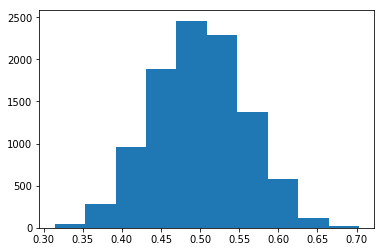

(1.0, 6.417226309630655, 2.52150067704172, 17.27725206236576, 100)


In [9]:
clear_output()
for dim in dims_scores:
    print(best_run)
    tup = dims_scores[dim]
    print(dim, tup)
    
#     print(best_probs[dim])
    
    probs = best_probs[dim]
    plt.hist(probs)
    plt.show()
    
    
    (loss, sd, mu_th,sd_th,minb,maxb) = tup
    offset = 1 - minb
    print((offset+minb, offset+maxb, offset+mu_th-3.0*sd_th, offset+mu_th+3.0*sd_th, dims))

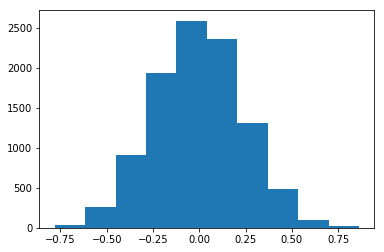

In [10]:
underlying = [inv_sigmoid(p) for p in probs]
plt.hist(underlying)
plt.show()

In [13]:
# # gaussian_pts = numpy.random.normal(5.15,1.51,1000)
# n_students = 100
# n_items = 100
# n_traits = 100
# gaussian_pts = numpy.random.normal(mu_th, sd_th, (n_students*n_traits))
# uniform_pts = numpy.random.uniform(minb, maxb, (n_items*n_traits))
# gaussian_pts = gaussian_pts.reshape(n_students, n_traits)
# uniform_pts = uniform_pts.reshape(n_items, n_traits )
# gaussian_pts = numpy.repeat(gaussian_pts, n_items, axis=0 )
# uniform_pts = numpy.tile(uniform_pts, (n_students,1) )

# print(gaussian_pts)
# print(uniform_pts)

# diffs = 1.0 / (1.0 + numpy.exp(-(gaussian_pts - uniform_pts)))
# pps = numpy.prod(diffs, axis=1)

# print(pps.shape)
# print(pps)

# # print((pt, u) for pt, u in zip(gaussian_pts, uniform_pts))
# # transformed_pts = [ numpy.prod(1.0 / (1.0 + exp(-(pt - u)))) for pt,u in zip(gaussian_pts,uniform_pts)]
# f,axes = plt.subplots(1,2)
# axes[0].hist(pps)
# plt.show()